In [5]:
pip install pyspark

In [50]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.feature import PCA as PCAml

In [51]:
import pandas as pd
import numpy as np

In [56]:
session = SparkSession.builder.appName("RegressionPipeline").getOrCreate()

In [57]:
data_path = "Airline_customer_satisfaction.csv"

In [58]:
data = session.read.csv(data_path, header=True, inferSchema=True)
# data.printSchema()
data.show(5)

+------------+--------------+---+---------------+--------+---------------+------------+---------------------------------+--------------+-------------+---------------------+----------------------+--------------+----------------------+----------------+----------------+----------------+---------------+-----------+---------------+--------------------------+------------------------+
|satisfaction| Customer Type|Age| Type of Travel|   Class|Flight Distance|Seat comfort|Departure/Arrival time convenient|Food and drink|Gate location|Inflight wifi service|Inflight entertainment|Online support|Ease of Online booking|On-board service|Leg room service|Baggage handling|Checkin service|Cleanliness|Online boarding|Departure Delay in Minutes|Arrival Delay in Minutes|
+------------+--------------+---+---------------+--------+---------------+------------+---------------------------------+--------------+-------------+---------------------+----------------------+--------------+----------------------+-----

Index string-typed columns by doing indexation for each column in a pipeline

In [59]:
# Check for missing values and data types
data.describe().show()
data.select([col(c).isNull().alias(c) for c in data.columns]).show()

+-------+------------+-----------------+------------------+---------------+--------+-----------------+------------------+---------------------------------+-----------------+------------------+---------------------+----------------------+------------------+----------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------------+------------------------+
|summary|satisfaction|    Customer Type|               Age| Type of Travel|   Class|  Flight Distance|      Seat comfort|Departure/Arrival time convenient|   Food and drink|     Gate location|Inflight wifi service|Inflight entertainment|    Online support|Ease of Online booking|  On-board service|  Leg room service|  Baggage handling|   Checkin service|       Cleanliness|   Online boarding|Departure Delay in Minutes|Arrival Delay in Minutes|
+-------+------------+-----------------+------------------+---------------+--------+-----------------+------

In [60]:
# Fill missing values in categorical columns with "Unknown"
categorical_columns = ['Customer Type', 'Type of Travel', 'Class']
for column in categorical_columns:
    data = data.withColumn(column, when(col(column).isNull(), "Unknown").otherwise(col(column)))

In [61]:
# Fill missing values in numerical columns with the mean value
numerical_columns = [
    'Age', 'Flight Distance', 'Seat comfort', 'Departure/Arrival time convenient', 'Food and drink',
    'Gate location', 'Inflight wifi service', 'Inflight entertainment', 'Online support',
    'Ease of Online booking', 'On-board service', 'Leg room service', 'Baggage handling',
    'Checkin service', 'Cleanliness', 'Online boarding', 'Departure Delay in Minutes',
    'Arrival Delay in Minutes'
]
for column in numerical_columns:
    mean_value = data.select(column).agg({column: 'mean'}).first()[0]
    data = data.na.fill(mean_value, subset=[column])

In [33]:
# Index the 'satisfaction' column (target variable)
satisfaction_indexer = StringIndexer(inputCol="satisfaction", outputCol="satisfaction_index").fit(data)


In [62]:
# Create indexers for categorical columns
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(data) for column in categorical_columns]

# Define input features for the model, including numerical columns and indexed categorical columns
input_features = numerical_columns + [column+"_index" for column in categorical_columns]

# Assemble features into a single vector
vectorAssembler = VectorAssembler(inputCols=input_features, outputCol="features")

# Standardize features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

# Initialize the logistic regression model
classifier = LogisticRegression(featuresCol="scaledFeatures", labelCol="satisfaction_index")

# Create a pipeline with all stages
pipeline = Pipeline(stages=indexers + [satisfaction_indexer, vectorAssembler, scaler, classifier])

In [63]:
# Split the data into training and test sets
(trainingData, testData) = data.randomSplit([0.7, 0.3], seed=42)

In [64]:
# Fit the pipeline to the training data
try:
    model = pipeline.fit(trainingData)
except Exception as e:
    print("Error fitting the pipeline: ", e)

In [65]:
# Make predictions on the test data
predictions = model.transform(testData)

In [66]:
# Evaluate the model using Binary Classification Evaluator
evaluator = BinaryClassificationEvaluator(labelCol="satisfaction_index", metricName="areaUnderROC")
areaUnderROC = evaluator.evaluate(predictions)
print("Area under ROC =", areaUnderROC)

Area under ROC = 0.9023667563933468


AUC-ROC = 0.902: This indicates that your logistic regression model has excellent performance. It means the model has a high ability to distinguish between the positive class (satisfied customers) and the negative class (dissatisfied customers).

In [67]:
# Get the logistic regression model from the pipeline
lr_model = model.stages[-1]

# Get the coefficients and feature names
coefficients = lr_model.coefficients
feature_names = model.stages[-3].getInputCols()  # This corresponds to the VectorAssembler stage

# Create a dictionary of feature names and their corresponding coefficients
feature_coefficients = dict(zip(feature_names, coefficients))

# Sort features by the absolute value of their coefficients (importance)
sorted_features = sorted(feature_coefficients.items(), key=lambda x: abs(x[1]), reverse=True)

# Print sorted feature importance
print("Feature importance:")
for feature, coef in sorted_features:
    print(f"{feature}: {coef}")

Feature importance:
Inflight entertainment: -0.9724886205555638
Customer Type_index: 0.7468885493469678
Type of Travel_index: 0.41625897819134844
On-board service: -0.4056252870901855
Seat comfort: -0.39105406776596324
Checkin service: -0.3663677698599108
Departure/Arrival time convenient: 0.3367557084089083
Leg room service: -0.31223696592898365
Ease of Online booking: -0.30874535844424966
Class_index: 0.29955787789576044
Arrival Delay in Minutes: 0.2953354333944044
Food and drink: 0.28466926309810603
Online boarding: -0.1941492083005166
Flight Distance: 0.18531277193189521
Gate location: -0.1497682789115738
Online support: -0.14418778097406698
Age: 0.1229684199870228
Inflight wifi service: 0.11723276466764293
Departure Delay in Minutes: -0.10874358387444055
Baggage handling: -0.10776268140062974
Cleanliness: -0.08293604800621263


Most Influential Negative Factors: Inflight entertainment, on-board service, seat comfort, and check-in service are the top negative influencers. Improving these areas could significantly boost customer satisfaction.

Most Influential Positive Factors: Customer type, type of travel, departure/arrival time convenience, and class of travel are the top positive influencers. Enhancing these aspects or targeting satisfied customer segments can help maintain high satisfaction levels.

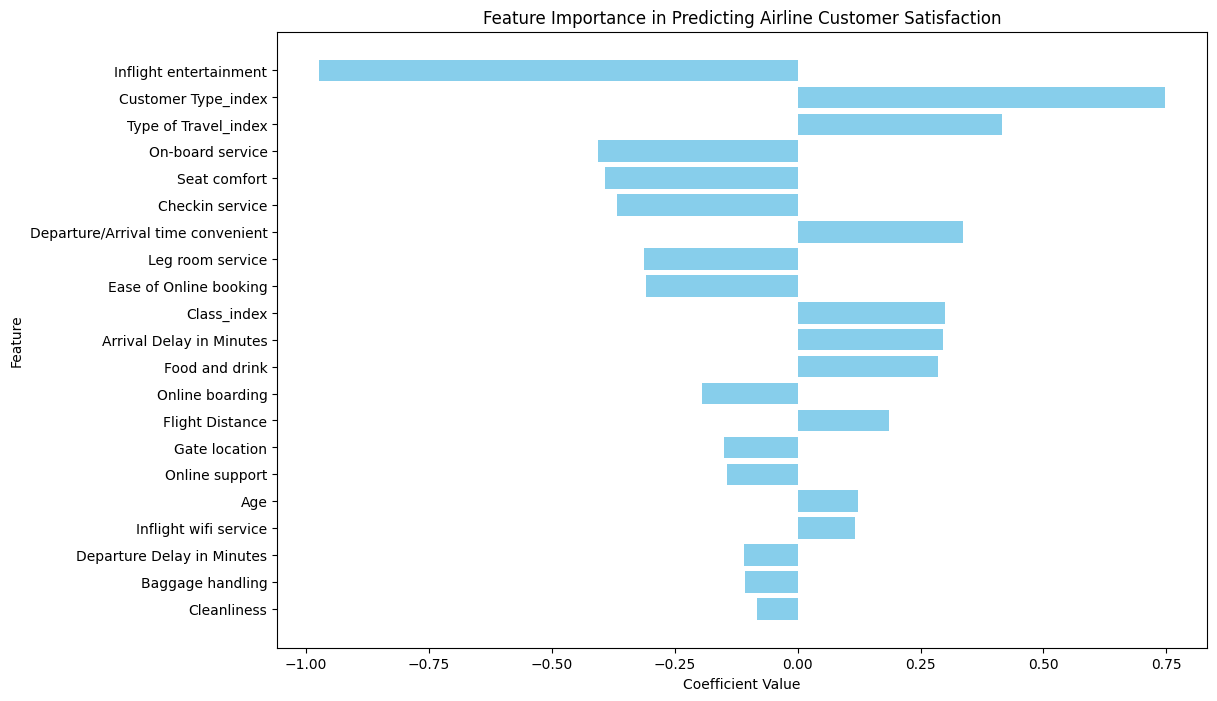

In [68]:
import matplotlib.pyplot as plt
import pandas as pd

# Prepare data for plotting
features = [feature for feature, coef in sorted_features]
coeffs = [coef for feature, coef in sorted_features]

# Create a DataFrame for sorting and visualization
df = pd.DataFrame({'Feature': features, 'Coefficient': coeffs})
df['Importance'] = df['Coefficient'].abs()

# Plot the bar chart
plt.figure(figsize=(12, 8))
plt.barh(df['Feature'], df['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance in Predicting Airline Customer Satisfaction')
plt.gca().invert_yaxis()
plt.show()

In [48]:
session.stop()